# Модуль B

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## 2.1 Отбор признаков

In [2]:
file = pd.read_csv('file_transformed.csv', index_col = 0)
file

,borough,neighborhood,building_class_category,tax_class,block,lot,building_class,address,zip_code,residential_units,...,YearAlter1,YearAlter2,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,CondoNo,TaxMap,APPBBL
1,0.0,-0.060606,37.0,2.25,-0.867889,13.095890,0.982609,0.118699,-0.857143,-1.0,...,9.905089,1182.411705,8.891616,3.341130,6.335205,1.541960,0.0,16.017166,-1.139996,27.665151
2,0.0,-0.121212,27.0,2.25,-0.885810,-0.602740,0.321739,0.805199,-0.857143,-1.0,...,0.000000,0.000000,-0.839415,2.091041,2.000000,1.288287,0.0,0.000000,-0.894741,17.339153
3,0.0,-0.515152,29.0,2.25,-0.854553,-0.602740,0.773913,0.015753,-0.857143,-1.0,...,3.465208,0.000000,4.488071,-0.804246,2.000000,-1.104246,0.0,0.000000,-0.891032,0.000000
4,0.0,0.515152,32.0,2.25,0.867889,0.136986,0.573913,0.414775,0.714286,-1.0,...,0.000000,0.000000,0.738685,-0.804246,2.000000,-1.104246,0.0,0.000000,0.886580,0.000000
5,0.0,-0.515152,40.0,2.25,-0.849135,-0.602740,0.408696,-0.288212,-0.857143,-1.0,...,3.496710,2000.000000,8.992930,0.172913,0.000000,0.662548,0.0,0.000000,-0.891032,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390879,0.0,1.090909,40.0,0.00,-0.201709,-0.356164,-0.017391,0.183108,0.857143,2.0,...,0.000000,0.000000,0.111922,0.172913,0.000000,0.662548,0.0,0.000000,-0.149124,0.000000
390880,0.0,1.090909,56.0,0.00,-0.201709,-0.356164,-0.017391,0.183108,0.857143,2.0,...,0.000000,0.000000,0.111922,0.172913,0.000000,0.662548,0.0,0.000000,-0.149124,0.000000
390881,0.0,1.090909,4.0,2.25,-0.213586,0.068493,1.452174,0.213119,0.857143,-1.0,...,0.000000,0.000000,-0.839415,0.172913,0.000000,0.662548,0.0,0.000000,-0.150607,0.000000
390882,0.0,-0.818182,4.0,2.50,0.537820,14.547945,1.460870,-0.727169,-0.238095,-1.0,...,1.289024,-16.101045,0.912040,0.822468,-0.342939,0.262835,0.0,17.698443,0.344736,2.700453


Для отбора признаков, влияющих на building_class_category, предположим, что все данные в столбцах являются случайными величинами. Построим корреляционные матрицы. Сперва для всех величин:

Text(0.5, 1.0, 'Correlation Matrix')

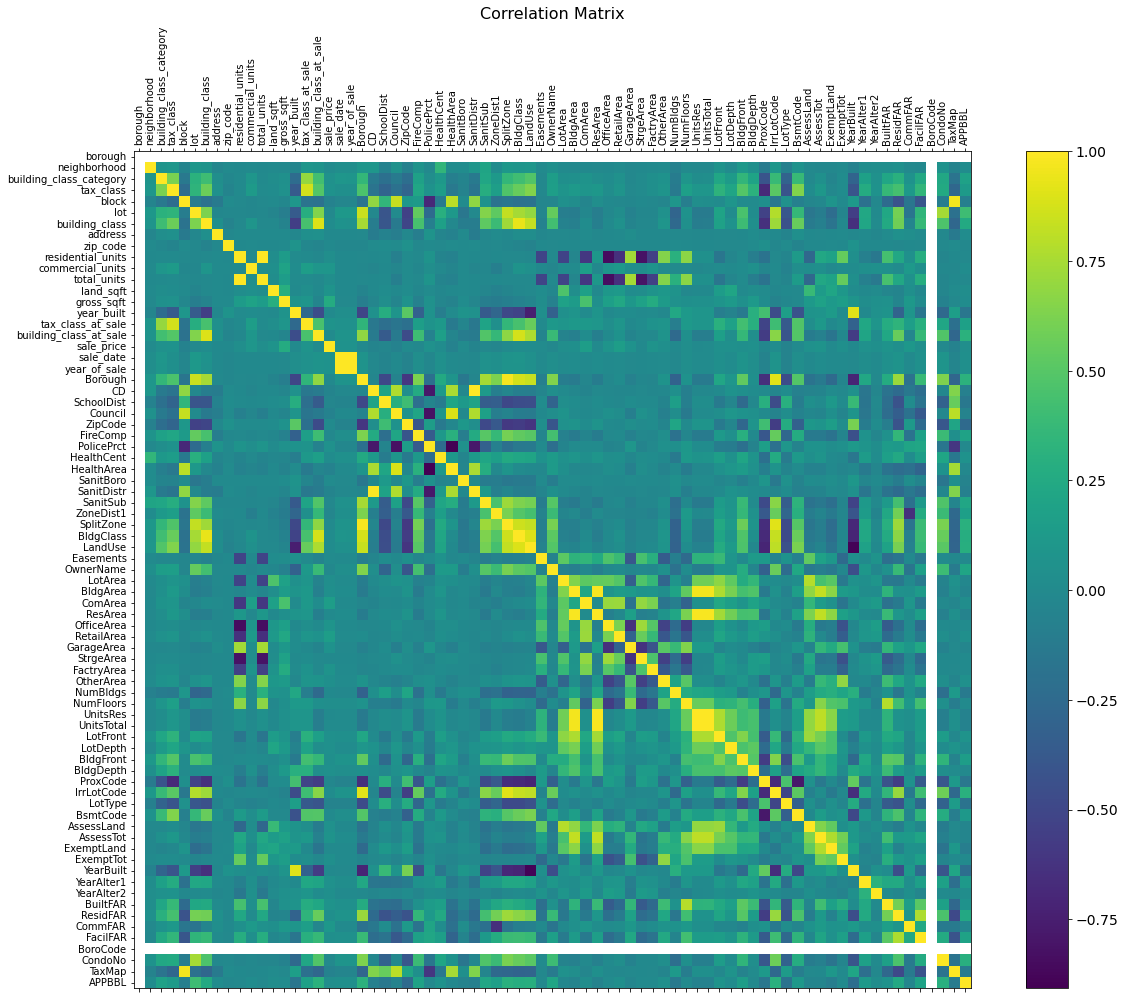

In [3]:
f = plt.figure(figsize=(20,15))
plt.matshow(file.corr(), fignum=f.number)
plt.xticks(range(len(file.columns)), file.columns, fontsize=10, rotation=90)
plt.yticks(range(len(file.columns)), file.columns, fontsize=10, va='center')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

А теперь для ```building_class_category``` отдельно, сортируя по убыванию

In [4]:
corr = pd.DataFrame(file.corr().building_class_category, 
                    columns=['building_class_category'], 
                    index=file.columns)
corr = corr.sort_values(by='building_class_category',
                        ascending=False,
                        key=lambda x: abs(x))
corr.style.background_gradient(cmap='coolwarm')

,building_class_category
building_class_category,1.000000
tax_class_at_sale,0.701368
tax_class,0.614287
LandUse,0.483492
building_class_at_sale,0.425795
BldgClass,0.417574
ProxCode,-0.414988
building_class,0.407813
IrrLotCode,0.381530
BsmtCode,0.378476


Как видно, важность факторов по модулю убывает постепенно, что не дает нам возможности четко отсечь признаки по значимости.

Возьмем переменные так, чтобы корреляция не была меньше 0.2 по модулю, построим графики зависимости этих переменных друг от друга. 

Переменные ```tax_class_at_sale``` и ```tax_class``` зачастую описывают одни и те же параметры, так что при рассмотрении возьмем переменную tax_class_at_sale. 

Такая же ситуация наблюдается и с переменными ```building_class_at_sale```, ```building_class```, ```BldgClass```. Воспользуемся переменной ```building_class_at_sale```.

In [5]:
exclude = ['building_class',
           'BldgClass', 
           'tax_class',
           'building_class_category']

taken = []
for i in corr.index:
    if i not in exclude and abs(corr.loc[i][0]) > 0.2:
        taken.append(i)
        if len(taken) == 20:
            break

Полученные переменные должны сильно коррелировать с основной переменной, но при этом должны быть слабо связаны между собой. Проиллюстрируем их связь между собой.

In [6]:
corr_taken = file.corr()
to_del_cols = []
for i in corr_taken.columns:
    if i not in taken:
        to_del_cols.append(i)
corr_taken = corr_taken.drop(columns=to_del_cols)
corr_taken = corr_taken.drop(index=to_del_cols)
corr_taken.style.background_gradient(cmap='coolwarm')

,lot,year_built,tax_class_at_sale,building_class_at_sale,Borough,ZipCode,SanitSub,SplitZone,LandUse,LotFront,BldgFront,ProxCode,IrrLotCode,LotType,BsmtCode,YearBuilt,BuiltFAR,ResidFAR,FacilFAR,CondoNo
lot,1.000000,-0.359303,0.283980,0.640979,0.849673,-0.539233,0.643287,0.826196,0.691006,0.197928,0.450189,-0.531763,0.778964,-0.392680,0.361326,-0.556597,0.229325,0.604030,0.342513,0.740952
year_built,-0.359303,1.000000,-0.255224,-0.453711,-0.505258,0.512251,-0.369789,-0.490961,-0.749720,-0.093207,-0.125583,0.432523,-0.467333,0.158728,-0.423527,0.917414,0.072543,-0.299798,-0.159474,-0.251639
tax_class_at_sale,0.283980,-0.255224,1.000000,0.452154,0.343383,-0.202152,0.197123,0.359295,0.555475,0.301294,0.422590,-0.514134,0.405480,-0.363211,0.483055,-0.306345,0.276834,0.331874,0.297857,0.220405
building_class_at_sale,0.640979,-0.453711,0.452154,1.000000,0.686553,-0.471975,0.478887,0.672574,0.763554,0.169619,0.363122,-0.569008,0.664274,-0.405609,0.489278,-0.566131,0.228675,0.555739,0.367266,0.481605
Borough,0.849673,-0.505258,0.343383,0.686553,1.000000,-0.603664,0.745228,0.973022,0.839370,0.223332,0.531162,-0.647936,0.917334,-0.468855,0.488870,-0.709535,0.268007,0.711298,0.383390,0.633123
ZipCode,-0.539233,0.512251,-0.202152,-0.471975,-0.603664,1.000000,-0.482965,-0.589834,-0.614633,-0.128359,-0.272136,0.416415,-0.557554,0.263454,-0.317366,0.605227,-0.093234,-0.417150,-0.238534,-0.391019
SanitSub,0.643287,-0.369789,0.197123,0.478887,0.745228,-0.482965,1.000000,0.722675,0.601156,0.140979,0.377245,-0.476204,0.662970,-0.343360,0.327988,-0.523722,0.128388,0.428088,0.122604,0.475500
SplitZone,0.826196,-0.490961,0.359295,0.672574,0.973022,-0.589834,0.722675,1.000000,0.826914,0.252387,0.567958,-0.657694,0.911924,-0.479242,0.495741,-0.690171,0.299363,0.724291,0.392030,0.615919
LandUse,0.691006,-0.749720,0.555475,0.763554,0.839370,-0.614633,0.601156,0.826914,1.000000,0.264110,0.465769,-0.706920,0.811381,-0.434681,0.613702,-0.888011,0.193825,0.607531,0.374578,0.509911
LotFront,0.197928,-0.093207,0.301294,0.169619,0.223332,-0.128359,0.140979,0.252387,0.264110,1.000000,0.638856,-0.350118,0.372200,-0.258053,0.320711,-0.146420,0.253251,0.217344,0.156456,0.150686


Рассчитаем среднюю корреляцию данных переменных:

In [7]:
means = {}
for i in corr_taken.columns:
    means[i] = np.mean(corr_taken[i])

means = list(means.items())
means.sort(key = lambda x: abs(x[1]))
means = dict(means)
means

{'year_built': -0.09555338314845162,
 'ZipCode': -0.15612304836114715,
 'YearBuilt': -0.17577615897922222,
 'LotType': -0.18163854743819352,
 'LotFront': 0.1841498220719592,
 'tax_class_at_sale': 0.2144866832068605,
 'BuiltFAR': 0.22911068420824582,
 'BsmtCode': 0.23042237105304167,
 'FacilFAR': 0.23950145975714326,
 'SanitSub': 0.24280396937853194,
 'CondoNo': 0.25863414583792865,
 'ProxCode': -0.26748153311364314,
 'building_class_at_sale': 0.27739227717286236,
 'LandUse': 0.28621587341694754,
 'BldgFront': 0.29628600371850944,
 'lot': 0.3130386704413687,
 'ResidFAR': 0.325950102452847,
 'Borough': 0.3329247993639487,
 'SplitZone': 0.33661935047453784,
 'IrrLotCode': 0.3434817333709543}

Видно, что эти переменные, хотя и связаны между собой, по большей части имеют несильную связь. Оставим те переменные, которые имеют средний коэффициент корреляции меньше 0.3

In [8]:
to_pop = [i for i in means if means[i] > 0.3 ]
for i in to_pop:
    means.pop(i)
means

{'year_built': -0.09555338314845162,
 'ZipCode': -0.15612304836114715,
 'YearBuilt': -0.17577615897922222,
 'LotType': -0.18163854743819352,
 'LotFront': 0.1841498220719592,
 'tax_class_at_sale': 0.2144866832068605,
 'BuiltFAR': 0.22911068420824582,
 'BsmtCode': 0.23042237105304167,
 'FacilFAR': 0.23950145975714326,
 'SanitSub': 0.24280396937853194,
 'CondoNo': 0.25863414583792865,
 'ProxCode': -0.26748153311364314,
 'building_class_at_sale': 0.27739227717286236,
 'LandUse': 0.28621587341694754,
 'BldgFront': 0.29628600371850944}

Визуализируем взаимосвязь этих переменных и целевой переменной. Расположим последнюю на оси ординат.

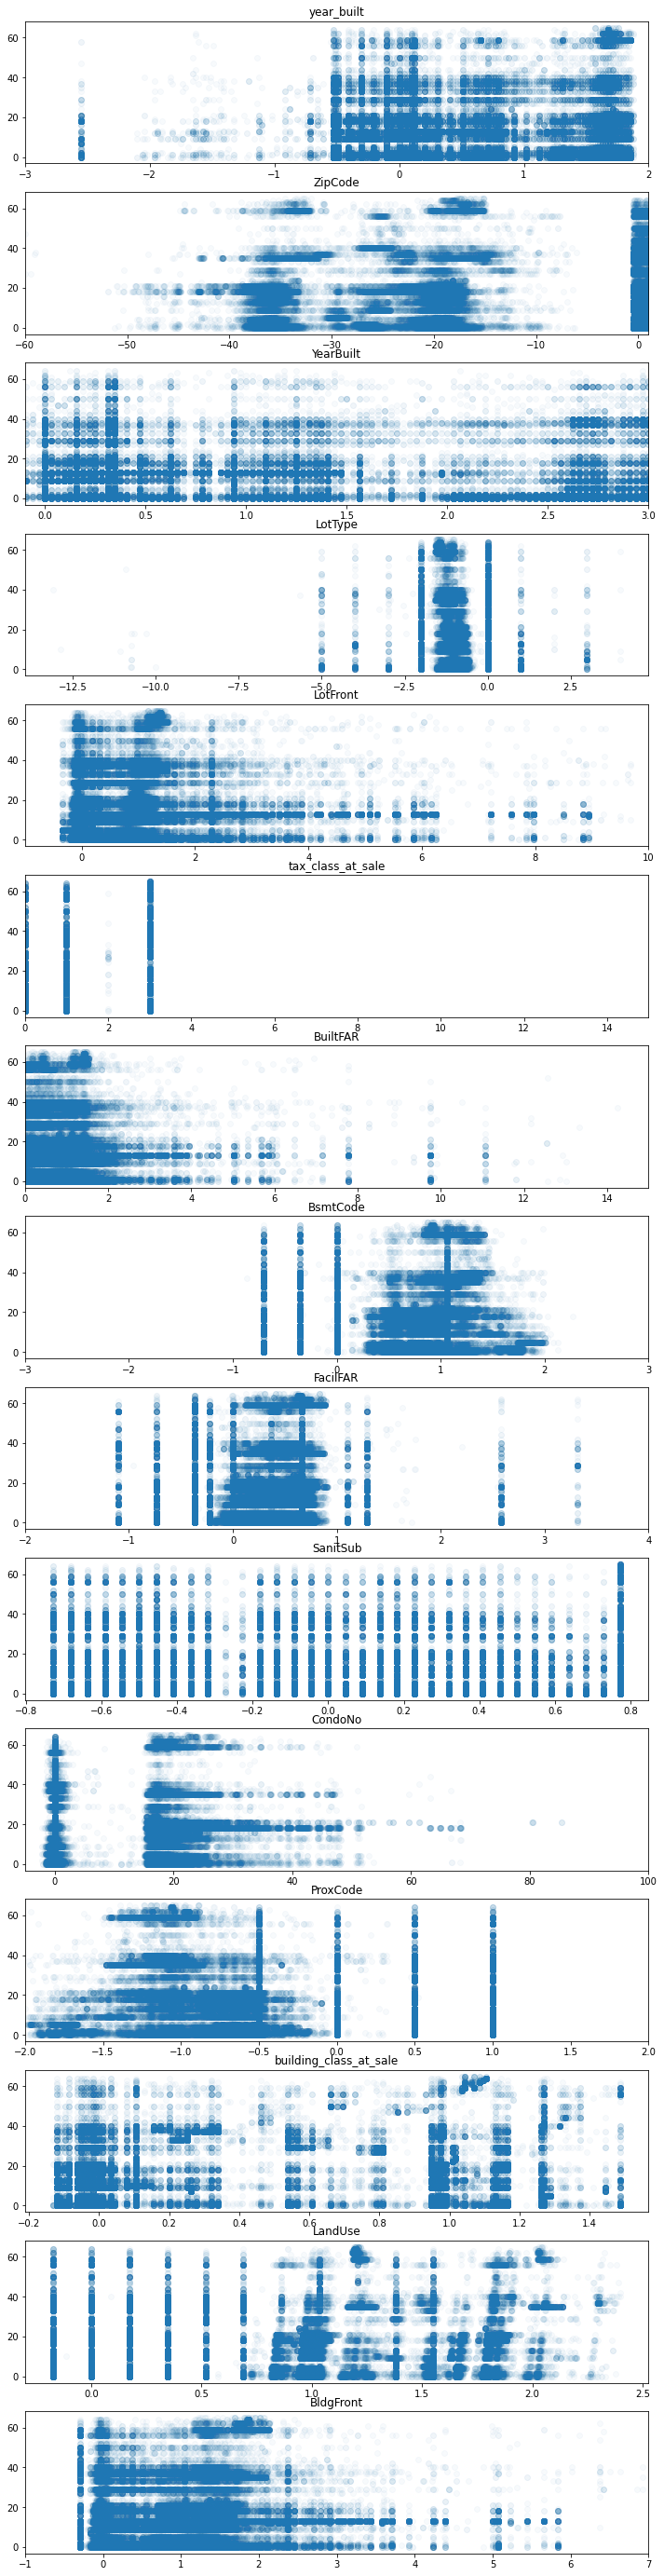

In [56]:
fig, axs = plt.subplots(15, 1,
                        **{'figsize': [12, 50]})
cnt1 = 0
cnt2 = 0
for i in means:
    if cnt1 == 0:
        axs[cnt1].set_xlim(left=-3, right=2)
    elif cnt1 == 1:
        axs[cnt1].set_xlim(left=-60)
    elif cnt1 == 2:
        axs[cnt1].set_xlim(left = -0.1, right=3)
    elif cnt1 == 4:
        axs[cnt1].set_xlim(left=-1, right=10)
    elif cnt1 == 5:
        axs[cnt1].set_xlim(right=15)
    elif cnt1 == 6:
        axs[cnt1].set_xlim(right=15)
    elif cnt1 == 7:
        axs[cnt1].set_xlim(left = -3, right=3)
    elif cnt1 == 8:
        axs[cnt1].set_xlim(left = -2, right=4)
    elif cnt1 == 10:
        axs[cnt1].set_xlim(left = -5, right=100)
    elif cnt1 == 11:
        axs[cnt1].set_xlim(left = -2, right=2)
    elif cnt1 == 14:
        axs[cnt1].set_xlim(left = -1, right=7)
    axs[cnt1].scatter(file[i], file['building_class_category'],
                            alpha=0.03)
    axs[cnt1].set_title(i)
    cnt1 += 1
    if cnt1 == 15:
        cnt2 += 1
        cnt1 = 0

Как видно из графиков, некоторые выбросы все же имеются. Однако, наблюдаемое количество не столь велико, чтобы спровоцировать некоторые отклонения при классификации. Наблюдаются некоторые закономерности во всех рассмотренных данных (например, по приближении к определенному значению количество точек, соответствующих разным классам building_class_category, возрастает, что может подсказывать о правильности использования выбранных переменных

## 2.2 Разбиение обработанных данных на обучающую и тестирующую выборки

Данные будем разбивать случайным образом в следующем соотношении: 

80% - обучающая выборка, 20% - тестовая.

Случайное разбиение хорошо тем, что оно позволяет модели выяснить как можно больше зависимостей между данными. 

К сожалению, стратификация в нашем случае невозможна, так как в некоторых классах находится по одному элементу, соответственно, их нельзя разместить в двух классах.

In [10]:
y = file.building_class_category
X = file.drop(columns=['building_class_category'])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

## 2.3 Классификация объектов

Для классификации будем пользоваться моделью ```SGD```, использующую стохастический градиентный спуск. Эта модель неплохо работает на данных больших размерностей, а также дает результат довольно быстро. Попробуем 5 моделей, в каждой будем менять функцию потерь. Каждую модель проверим с помощью трехпроходной кросс-валидации.

In [11]:
search_grid_SGD = {'loss': ['hinge',
                            'log',
                            'modified_huber',
                            'squared_hinge',
                            'perceptron'],
                   'alpha': [0.0001]}
sgd = SGDClassifier()
sgBest = GridSearchCV(sgd, search_grid_SGD, verbose=3, cv=3)
sgBest.fit(X_train, y_train)
sgBest.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/pavel/Desktop/DS2021_Qual/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


[CV 1/3] END ..........alpha=0.0001, loss=hinge;, score=0.386 total time=  39.8s
[CV 2/3] END ..........alpha=0.0001, loss=hinge;, score=0.345 total time= 1.1min
[CV 3/3] END ..........alpha=0.0001, loss=hinge;, score=0.322 total time=  41.7s
[CV 1/3] END ............alpha=0.0001, loss=log;, score=0.360 total time=  44.3s
[CV 2/3] END ............alpha=0.0001, loss=log;, score=0.342 total time= 1.1min
[CV 3/3] END ............alpha=0.0001, loss=log;, score=0.318 total time=  44.5s
[CV 1/3] END .alpha=0.0001, loss=modified_huber;, score=0.337 total time=  38.0s
[CV 2/3] END .alpha=0.0001, loss=modified_huber;, score=0.350 total time= 1.1min
[CV 3/3] END .alpha=0.0001, loss=modified_huber;, score=0.314 total time=  43.8s
[CV 1/3] END ..alpha=0.0001, loss=squared_hinge;, score=0.322 total time=  49.7s
[CV 2/3] END ..alpha=0.0001, loss=squared_hinge;, score=0.323 total time=  55.6s
[CV 3/3] END ..alpha=0.0001, loss=squared_hinge;, score=0.308 total time=  45.6s
[CV 1/3] END .....alpha=0.00

0.3506071680050146

Как видно из результатов сравнения, среди 5 моделей с разными параметрами лучше всего показала себя модель c функцией потерь `hinge`. Её и будем использовать для дальнейшей классификации. Построим оценки для каждой модели по метрикам accuracy, precision и recall, отобразим их на графике.

In [31]:
sgd = sgBest.best_estimator_

sgd.fit(X_train, y_train)
y_pred_best = sgd.predict(X_test)

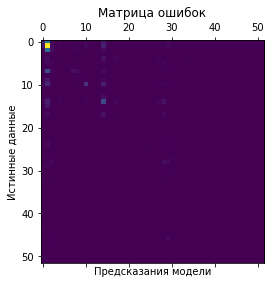

Accuracy of best: 0.3424792458139862
Recall of best: 0.3424792458139862
Precision of best: 0.3424792458139862


In [44]:
plt.matshow(confusion_matrix(y_test, y_pred_best))
plt.title("Матрица ошибок")
plt.ylabel('Истинные данные')
plt.xlabel('Предсказания модели')
plt.show()
print(f"Accuracy of best: {accuracy_score(y_test, y_pred_best)}",
      f"Recall of best: {recall_score(y_test, y_pred_best, average='micro')}",
      f"Precision of best: {precision_score(y_test, y_pred_best, average='micro')}", sep='\n')

Подобный результат намного лучше, чем если бы модель выдавала константный результат, однако все же далек от идеала. Судя по матрице ошибок и по строению датасета, в последнем видно крайне неравномерное разделение классов, из-за чего модель "переучивается" и во многих подаваемых данных видит самый частый класс, хотя иногда и дает иной, правильный ответ. Построим похожие данные для других моделей.

Accuracy of log: 0.29823349578520536
Recall of log: 0.29823349578520536
Precision of log: 0.29823349578520536


Accuracy of modified_huber: 0.3342031543804444
Recall of modified_huber: 0.3342031543804444
Precision of modified_huber: 0.3342031543804444


Accuracy of squared_hinge: 0.35510444248308326
Recall of squared_hinge: 0.35510444248308326
Precision of squared_hinge: 0.35510444248308326


Accuracy of perceptron: 0.3360451283625619
Recall of perceptron: 0.3360451283625619
Precision of perceptron: 0.3360451283625619




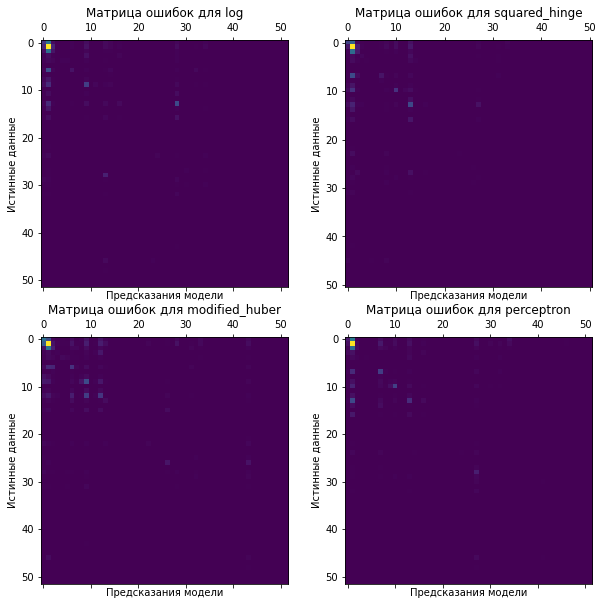

In [48]:
losses =  ['log', 'modified_huber', 'squared_hinge', 'perceptron']

fig, axs = plt.subplots(2,2, **{'figsize': [10,10]})
cnt1 = 0
cnt2 = 0
for i in losses:
    sgd = SGDClassifier(loss=i)
    sgd.fit(X_train, y_train)
    y_pred1 = sgd.predict(X_test)
    axs[cnt1][cnt2].matshow(confusion_matrix(y_test, y_pred1))
    axs[cnt1][cnt2].set_ylabel('Истинные данные')
    axs[cnt1][cnt2].set_xlabel('Предсказания модели')
    axs[cnt1][cnt2].set_title(f"Матрица ошибок для {i}")
    cnt1 += 1
    if cnt1 == 2:
        cnt1 = 0
        cnt2 += 1
    
    print(f"Accuracy of {i}: {accuracy_score(y_test, y_pred1)}",
          f"Recall of {i}: {recall_score(y_test, y_pred1, average='micro')}",
          f"Precision of {i}: {precision_score(y_test, y_pred1, average='micro')}", '\n', sep='\n')

Как видно, оценка у модели ```Squared Hinge``` оказалась несколько выше, чем у выбранной нами модели. Думаю, что это связано с наличием дополнительных данных, которые не попадали в некоторые тренировочные выборки при кросс-валидации. Тем не менее, выбранная нами модель является второй по качеству, так что выбор, в целом, удачный. Более того, мы не тестировали модели на датасетах с одинаковым распределением классов. 